In [65]:
import os

import matplotlib.pyplot as plot
from matplotlib.colors import LogNorm
import swiftsimio as sw
from swiftsimio.objects import InvalidConversionError

# Simulation directory structure

Before we start looking at the data let's take a quick look at how everything is stored.

All simulations are kept at `/cosma8/data/dp004/colibre/Runs`. Here you will see a collection of directories with names of the form `LXXXXNYYYY`. The value of `XXXX` corresponds to the simulation box side length in comoving Mpc, and the value of `YYYY` is the number of gas particles per linear dimension. Each simulation has four times as many dark matter particles as gas. We will use one of the `L0025N0376` simulations, meaning they have a volume of $(25\mathrm{Mpc})^3$, $376^3$ gas particles, and $4 \times 376^3$ dark matter particles.

For each box size and resolution we have a multiple simulations. Each of these has a different set of subgrid models (the way we include physical processes in the simulation, e.g. black hole feedback). For this notebook we will use the `Fiducial_test` simulation.

Let's list what's present inside the simulation directory:

In [11]:
!ls /cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test

colibre_L025N0376.yml	 pipeline_output	  SNII.txt
colibre.xmf		 rank_cpu_balance.log	  SOAP
data_0123.yml		 rank_hostname.log	  statistics.txt
dependency_graph_-1.csv  rank_memory_balance.log  submit.slurm
HBTplus			 resub.sh		  swift-colibre
logs			 resub.slurm		  task_level_0000_-1.txt
output_fields.yml	 r_processes.txt	  timesteps.txt
output_list_ps.txt	 SFR.txt		  unused_parameters.yml
output_list.txt		 snapshots		  used_parameters
partition_fixed_costs.h  SNIa.txt


You probably don't won't ever need to look at most of these files. The most important files/directories (which we'll look at below) are:
- `snapshots` This directory contains the particles and their properties output by the simulation at different times
- `SOAP` This directory contains the halo catalogues
- `HBTplus` This directory contains the full halo merger tree information for the simulation
- `output_list.txt` This file lists the redshifts at which snapshots have been created

Let's print the first few lines of `output_list.txt` 

In [15]:
!head -5 /cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test/output_list.txt

# Redshift, Select Output
30.000000, Snapshot
25.000000, Snipshot
22.500000, Snipshot
20.000000, Snapshot


We can see that the first snapshot (`snap_nr=0` since the files are 0-indexed) corresponds to `z=30`. If we want the `z=20` snapshot we will need to load `snap_nr=3`.

For some redshifts we output all the particle properties. For others we output a reduced file with significantly less properties, which are called snipshots.

# Snapshot datasets

Analysis of SWIFT snapshots should be carried out using [swiftsimio](https://swiftsimio.readthedocs.io/en/latest/index.html). This ensures that all units will be handled correctly (internal cosmological simulation units can be strange), and contains a lot of useful functionality for working with the files.


Within the `snapshots` directory there is a directory for each snapshot. Each of these contains a number of "chunk" files, named `colibre_xxxx.y.hdf5`. There is also a virtual file named `colibre_xxxx.hdf5`. **You should always load the virtual file rather than the chunk files**. Each chunk file only contains a subset of the total number of particles in the simulation, but if you use the virtual file you will have access to all the particles. Even if you only want to load a small region of the simulation you should use the virtual file combined with swiftsimio's masking ability (see below).

We begin by loading the `z=1` snapshot.

In [107]:
simulation_dir = "/cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test"
# For this test run we only had 124 snapshots, but all the main simulations have 128 snapshots, so double-check you have the correct snapshot.
snap_nr = 88
snapshot_filename = f"{simulation_dir}/snapshots/colibre_{snap_nr:04}/colibre_{snap_nr:04}.hdf5"
snap = sw.load(snapshot_filename)

### Metadata and loading particle properties

Basic information about the simulation can be accessed through the metadata attribute

In [43]:
print(f"Boxsize: {snap.metadata.boxsize}")
print(f"Redshift: {snap.metadata.redshift}")
print(f"Omega_lambda {snap.metadata.cosmology['Omega_cdm']}")
print(f"Number of gas particles: {snap.metadata.n_gas}")

Boxsize: [25.00000001 25.00000001 25.00000001] Mpc
Redshift: 1.0
Omega_lambda [0.256011]
Number of gas particles: 50971999


All the gas particle properties are contained within `snap.gas` (likewise for `snap.dark_matter`, `snap.stars`, `snap.black_holes`). For example the mass of the gas particles

In [46]:
print(snap.gas.masses)
print(snap.gas.masses.shape)

[0.00019066 0.00019555 0.00018962 ... 0.00018733 0.00019002 0.00018751] 10000000000.0*Msun (Comoving)
(50971999,)


You can find out what properties are available by using tab completion, or within the metadata. The property descriptions can also be accessed from the swiftsimio object.

In [69]:
print(snap.metadata.gas_properties.field_names[:3])
print(snap.gas.last_energies_received_from_agnfeedback.name)

['averaged_star_formation_rates', 'compton_yparameters', 'coordinates']
The energy the particles received the last time they were heated by AGN feedback. Not masked.


Each dataset has units associated with them that are automatically read in from the snapshot. Data is initially loaded in the simulation units, but it is easy to convert to your unit of choice.

**Specify the units you want, don't assume the datasets have the units you expect**

In [45]:
mass_msun = snap.gas.masses.to("Msun")
print(np.log10(mass_msun))

[6.280249  6.291265  6.2778854 ... 6.2726173 6.2788067 6.2730255]


Swiftsimio will automatically combine units for you, and will throw an error if you try and combine datasets in an inconsistent way

In [54]:
volume = snap.gas.masses / snap.gas.densities
print("Volume:", volume)

try:
    snap.gas.masses + snap.gas.densities
except ValueError:
    print("You can't combine those!")

Volume: [0.00295246 0.00265667 0.00187379 ... 0.0007878  0.0006287  0.00054782] Mpc**3 (Comoving)
You can't do that!


Properties are stored as co-moving quantities. This means you may need to convert them to physical depending on your use case

In [57]:
print("Comoving positions")
snap.gas.coordinates[:10]

Comoving positions


cosmo_array([[0.2611892, 0.0491192, 7.8849302],
       [0.1353292, 0.0343112, 8.1291142],
       [0.2246172, 0.3370582, 8.1658752],
       [0.0839512, 0.2286102, 8.1874442],
       [0.2007642, 0.3070582, 8.0156952],
       [0.1674202, 0.2194162, 8.0857712],
       [0.3428662, 0.2435992, 8.1275442],
       [0.1757712, 0.2412162, 7.8746612],
       [0.2978952, 0.1163872, 8.0569282],
       [0.0676302, 0.2984932, 8.1075112]], 'Mpc', comoving=True)

In [58]:
print("Physical positions")
snap.gas.coordinates[:10].to_physical()

Physical positions


cosmo_array([[0.1305946, 0.0245596, 3.9424651],
       [0.0676646, 0.0171556, 4.0645571],
       [0.1123086, 0.1685291, 4.0829376],
       [0.0419756, 0.1143051, 4.0937221],
       [0.1003821, 0.1535291, 4.0078476],
       [0.0837101, 0.1097081, 4.0428856],
       [0.1714331, 0.1217996, 4.0637721],
       [0.0878856, 0.1206081, 3.9373306],
       [0.1489476, 0.0581936, 4.0284641],
       [0.0338151, 0.1492466, 4.0537556]], 'Mpc', comoving=False)

Some properties (for which it does not make sense to refer to as comoving) cannot be converted. This can be checked with the `valid_transform` attribute.

In [66]:
print('Coordinates have valid transform?', snap.gas.coordinates.valid_transform)
print('Coordinate have valid transform?', snap.gas.last_agnfeedback_scale_factors.valid_transform)

try:
    snap.gas.last_agnfeedback_scale_factors.to_comoving()
except InvalidConversionError:
    print("You can't transform that!")

Coordinates have valid transform? True
Coordinate have valid transform? False
You can't transform that!


If you need a numpy array of the dataset, use `.value`

In [68]:
snap.gas.coordinates.value

array([[ 0.2611892 ,  0.0491192 ,  7.8849302 ],
       [ 0.1353292 ,  0.0343112 ,  8.1291142 ],
       [ 0.2246172 ,  0.3370582 ,  8.1658752 ],
       ...,
       [24.91037948, 24.90664348, 18.72689548],
       [24.81210748, 24.88645748, 18.65617348],
       [24.94263648, 24.98478748, 18.65686148]])

Certain properties have multiple columns, which you can access by specifying the name of the column you want

In [72]:
print(snap.stars.luminosities)
print(snap.stars.luminosities.GAMA_u)

Named columns instance with ['GAMA_u', 'GAMA_g', 'GAMA_r', 'GAMA_i', 'GAMA_z', 'GAMA_Y', 'GAMA_J', 'GAMA_H', 'GAMA_K'] available for "luminosities"
[4160. 3620. 3652. ... 3448. 7448. 4712.] dimensionless (Physical)


### Masking

SWIFT outputs files which are spatially sorted. This means it is possible to load the particles within a certain section of the simulation volume, rather than having to load everything. This can significantly reduce the time spent loading data.

Let's load the same snapshot as before, but only the corner of the box. Once loaded the object behaves the same as before.

In [108]:
mask = sw.mask(snapshot_filename)
boxsize = mask.metadata.boxsize

# Specify the region of the box we want to load (this requires units)
load_region = [[0.0 * b, 0.2 * b] for b in boxsize]
print('Load region:', load_region)

mask.constrain_spatial(load_region)
snap = sw.load(snapshot_filename, mask=mask)
print(f"Number of gas particles: {snap.metadata.n_gas}")

Load region: [[unyt_quantity(0., 'Mpc'), unyt_quantity(5., 'Mpc')], [unyt_quantity(0., 'Mpc'), unyt_quantity(5., 'Mpc')], [unyt_quantity(0., 'Mpc'), unyt_quantity(5., 'Mpc')]]
Number of gas particles: 50971999


This works because SWIFT groups particles into cells. Any cells that overlap with the load region specified will be loaded. This means that you will often end up loading some particles outside of the load region specified, so you need to apply your own mask if you don't want particles outside the load region. 

In [109]:
print(np.max(snap.gas.coordinates))

24.999999103039027 Mpc (Comoving)


### Visualisation

Sometimes you may want to visualise a set of particles or specific region of the simulation in order to gain insight into what enviroment a galaxy exists in. [Swiftsimio supports multiple options for this](https://swiftsimio.readthedocs.io/en/latest/visualisation/index.html)

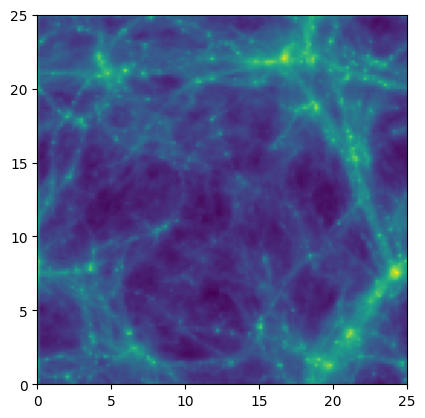

In [120]:
snap = sw.load(snapshot_filename)
boxsize = snap.metadata.boxsize[0].to('Mpc').value
extent = [0, boxsize, 0, boxsize]

mass_map = sw.visualisation.projection.project_gas(
    snap,
    resolution=128,
    project="masses",
    parallel=True,
    periodic=True,
)

mass_map = mass_map.to('Msun/kpc**2').value

plt.imshow(LogNorm()(mass_map), cmap="viridis", extent=extent)

In [119]:
extent

[0,
 array([25.00000001, 25.00000001, 25.00000001]),
 0,
 array([25.00000001, 25.00000001, 25.00000001])]

In [113]:
mass_map.to('Msun/kpc**2')

cosmo_array([[355620.25 , 148205.67 , 155845.5  , ..., 120929.42 , 196688.   ,
        227758.86 ],
       [156548.9  ,  91598.2  ,  91644.445, ...,  67411.55 ,  92966.34 ,
         83055.4  ],
       [139542.48 ,  80315.75 ,  79512.2  , ...,  75587.42 ,  78390.72 ,
         77505.695],
       ...,
       [231587.25 , 116796.625, 146130.61 , ...,  90266.21 , 107289.87 ,
        142377.81 ],
       [510422.5  , 101387.34 , 107221.07 , ...,  78121.92 , 146108.   ,
        412024.1  ],
       [241491.27 ,  88179.875,  92947.04 , ...,  73750.99 , 133629.84 ,
        170785.08 ]], dtype=float32, units='Msun/kpc**2', comoving=True)

In [114]:
mass_map

cosmo_array([[355620.25 , 148205.67 , 155845.5  , ..., 120929.42 , 196688.   ,
        227758.86 ],
       [156548.9  ,  91598.2  ,  91644.445, ...,  67411.55 ,  92966.34 ,
         83055.4  ],
       [139542.48 ,  80315.75 ,  79512.2  , ...,  75587.42 ,  78390.72 ,
         77505.695],
       ...,
       [231587.25 , 116796.625, 146130.61 , ...,  90266.21 , 107289.87 ,
        142377.81 ],
       [510422.5  , 101387.34 , 107221.07 , ...,  78121.92 , 146108.   ,
        412024.1  ],
       [241491.27 ,  88179.875,  92947.04 , ...,  73750.99 , 133629.84 ,
        170785.08 ]], dtype=float32, units='1.98841586e+30*kg/kpc**2', comoving=True)

In [89]:
soap_filename

'/cosma8/data/dp004/colibre/Runs/L0025N0376/Fiducial_test/SOAP/halo_properties_0088.hdf5'

In [ ]:
- Visualising volume (for environment)

In [8]:
Masking (summary swift output structure)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4239921561.py, line 1)

# SOAP

Link to current SOAP pdf

Tell us what properties you want

In [6]:
Datasets from pipeline, how to use

SyntaxError: invalid syntax (1570704140.py, line 1)

In [4]:
Reproduce pipeline plot

SyntaxError: invalid syntax (1626685914.py, line 1)

In [5]:
Subset writing?

Object `writing` not found.


# Merger trees

# SWIFT galaxy

In [2]:
Membership files

SyntaxError: invalid syntax (396452833.py, line 1)

In [ ]:
- Visualising objects